In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_excel('/kaggle/input/tennv2/Region_TEN - Copy.xlsx')

In [3]:
df = df[['UTC time', 'Local date', 'Hour', 'Local time', 'Demand']]

In [4]:
df = df.dropna()

In [5]:
# Load DataFrame (assuming it's already loaded as df)
df['UTC time'] = pd.to_datetime(df['UTC time'])
df.set_index('UTC time', inplace=True)
df = df.sort_index()

# Check for missing values and drop them if any
df = df.dropna(subset=['Demand'])

In [6]:
daily_avg_df = df.groupby('Local date', as_index=False)['Demand'].sum()

# Rename the column to clarify it's a daily average
daily_avg_df.rename(columns={'Demand': 'Daily Average Demand'}, inplace=True)

daily_avg_df['Local date'] = pd.to_datetime(daily_avg_df['Local date'])

# Filter for summer months (June, July, August)
summer_df = daily_avg_df[daily_avg_df['Local date'].dt.month.isin([6, 7, 8])]

In [7]:
df = summer_df

In [8]:
# Ensure the 'Local date' column is in datetime format
df['Local date'] = pd.to_datetime(df['Local date'])

# Set the 'Local date' column as the index
df.set_index('Local date', inplace=True)

# Rename the column to something simpler
df.rename(columns={'Daily Average Demand': 'Demand'}, inplace=True)

<ipython-input-8-af0a5d0a63d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Local date'] = pd.to_datetime(df['Local date'])
<ipython-input-8-af0a5d0a63d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Daily Average Demand': 'Demand'}, inplace=True)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from transformers import PatchTSTConfig, PatchTSTForPrediction, AutoformerModel, AutoformerConfig, AutoformerForPrediction, TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction, InformerConfig, InformerForPrediction, is_torch_xla_available
import torch
from transformers.modeling_outputs import Seq2SeqTSPredictionOutput, SampleTSPredictionOutput
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import normalize
import os
from kaggle_secrets import UserSecretsClient
import kaggle_secrets
from transformers.optimization import Adafactor, get_cosine_schedule_with_warmup, AdamW
from transformers import Trainer, TrainingArguments
from datetime import timedelta
from pandas.tseries.offsets import BDay
import torch.nn as nn
torch.manual_seed(0)
from typing import List, Optional, Tuple, Union
import gc
import random
from IPython.display import display
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'notebook'
from torchmetrics.regression import MeanAbsolutePercentageError
from plotly.offline import iplot
from scipy import stats
random.seed(0)
plt.rcParams.update({'font.size': 12})
np.random.seed(0)

In [10]:
def seedBasic(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
import torch
def seedTorch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
def seedEverything(seed):
    seedBasic(seed)
    seedTorch(seed)
    
seedEverything(2007)

In [11]:
class MainConfig:
    context_length = 70
    lags_sequence = [1, 2, 3, 4, 7, 60]
    prediction_length = 90
    wandb = False
    train_batch_size = 8
    valid_batch_size = 16
    lr = 5e-3
    epochs = 500
    device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
class StockDataset(Dataset):
    def __init__(self, dict_values):
        self.dict_values = dict_values
        
    def __len__(self):
        return len(self.dict_values["past_values"])
    
    def __getitem__(self, idx):
        return {
            k : torch.tensor(v[idx]).float() for k, v in self.dict_values.items() 
        }

In [13]:
def build_dataset(validation=False):
    data = df
    data["date"] = pd.to_datetime(df.index)
    data["target"] = data["Demand"]
    data["year"] = pd.to_datetime(data.index).year
    data["month"] = pd.to_datetime(data.index).month
    data["day"] = pd.to_datetime(data.index).day
    data["hour"] = pd.to_datetime(data.index).year
    remainder = len(data) % 7
    data = data[remainder:]
    
    if (validation):
        valid_data = data[-35:]
        data = data[:-35]
    
    past_values = []
    past_time_features = []
    past_observed_mask = []
    future_values = []
    future_time_features = []
    
    valid_past_values = []
    valid_past_time_features = []
    valid_past_observed_mask = []
    valid_future_values = []
    valid_future_time_features = []
    
    for i in range(0, len(data) - MainConfig.context_length - MainConfig.prediction_length - max(MainConfig.lags_sequence), MainConfig.context_length + MainConfig.prediction_length + max(MainConfig.lags_sequence)):
        past_values.append(data["target"].values[i : i + MainConfig.context_length + max(MainConfig.lags_sequence)])
        past_time_features.append(data[["year", "month", "day", "hour"]].values[i : i + MainConfig.context_length + max(MainConfig.lags_sequence)])
        past_observed_mask.append([1] * (MainConfig.context_length + max(MainConfig.lags_sequence)))

        future_values.append(data["target"].values[i + MainConfig.context_length + max(MainConfig.lags_sequence): i + MainConfig.context_length + max(MainConfig.lags_sequence) + MainConfig.prediction_length])
        future_time_features.append(data[["year", "month", "day", "hour"]].values[i + MainConfig.context_length + max(MainConfig.lags_sequence) : i + MainConfig.context_length + MainConfig.prediction_length + max(MainConfig.lags_sequence)])
                
    if validation:
        valid_past_values.append(data["target"].values[-(MainConfig.context_length + max(MainConfig.lags_sequence)):])
        valid_past_time_features.append(data[["year", "month", "day", "hour"]].values[-(MainConfig.context_length + max(MainConfig.lags_sequence)):])
        valid_past_observed_mask.append([1] * (MainConfig.context_length + max(MainConfig.lags_sequence)))

        valid_future_values.append(valid_data["target"].values)
        valid_future_time_features.append(valid_data[["year", "month", "day", "hour"]].values)
        
    if validation:
        return ({
            "past_values" : past_values,
            "past_time_features" : past_time_features,
            "past_observed_mask" : past_observed_mask,
            "future_values" : future_values,
            "future_time_features" : future_time_features,
        }, 
        {
            "past_values" : valid_past_values,
            "past_time_features" : valid_past_time_features,
            "past_observed_mask" : valid_past_observed_mask,
            "future_values" : valid_future_values,
            "future_time_features" : valid_future_time_features,
            })
    else:
        return ({
            "past_values" : past_values,
            "past_time_features" : past_time_features,
            "past_observed_mask" : past_observed_mask,
            "future_values" : future_values,
            "future_time_features" : future_time_features,
        })

In [14]:
class CustomTrainer(Trainer):
    def evaluate(self, ignore_keys = None, metric_key_prefix = "eval"):
        dl = DataLoader(self.eval_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        total_loss = 0
        
        for sample in dl:
            sample = {k : v.to(MainConfig.device) for k, v in sample.items()}
            targets = sample.pop("future_values")
            output = self.model.generate(**sample).sequences.mean(1)
            total_loss += MeanAbsolutePercentageError().to(MainConfig.device)(output.squeeze(), targets.squeeze()).detach().cpu().numpy()
        
        print(total_loss / len(dl) * 100)
            
        return {"loss" : total_loss / len(dl)}

In [15]:
def get_future_dates():
    future_dates = []
    
    # Generate business days for June, July, and August for the next 20 years
    for year in range(datetime.now().year, datetime.now().year + 20):
        for month in [6, 7, 8]:  # June (6), July (7), August (8)
            # Create a date range for the current month of the current year
            month_start = pd.Timestamp(f"{year}-{month:02d}-01")
            # Calculate the last day of the month
            month_end = pd.Timestamp(f"{year}-{month:02d}-{pd.Timestamp(year, month, 1).days_in_month}")
            
            # Generate all business days in the range
            business_days = pd.date_range(start=month_start, end=month_end, freq=BDay())
            
            # Convert each business day to a list of [year, month, day, hour]
            for day in business_days:
                future_dates.append([day.year, day.month, day.day, 0])  # 0 for hour (midnight)
    
    return future_dates

In [16]:
def get_past_dates(time_back):
    future_dates = [datetime.now() + BDay(-x) for x in list(range(1, time_back+1))[::-1]]
    
    values = []
    
    for date in future_dates:
        for hour in range(9, 16):
            values.append(f"{date.month}/{date.day}/{date.year} -- {hour}:30")
    
    return values

In [17]:
def get_future(time_back):
    future_dates = [datetime.now() + BDay(x) for x in list(range(0, time_back))]
    
    values = []
    
    for date in future_dates:
        for hour in range(9, 16):
            values.append(f"{date.month}/{date.day}/{date.year} -- {hour}:30")
    
    return values

In [18]:
def weighted_average(input_tensor: torch.Tensor, weights: Optional[torch.Tensor] = None, dim=None) -> torch.Tensor:
    """
    Computes the weighted average of a given tensor across a given `dim`, masking values associated with weight zero,
    meaning instead of `nan * 0 = nan` you will get `0 * 0 = 0`.

    Args:
        input_tensor (`torch.FloatTensor`):
            Input tensor, of which the average must be computed.
        weights (`torch.FloatTensor`, *optional*):
            Weights tensor, of the same shape as `input_tensor`.
        dim (`int`, *optional*):
            The dim along which to average `input_tensor`.

    Returns:
        `torch.FloatTensor`: The tensor with values averaged along the specified `dim`.
    """
    if weights is not None:
        weighted_tensor = torch.where(weights != 0, input_tensor * weights, torch.zeros_like(input_tensor))
        sum_weights = torch.clamp(weights.sum(dim=dim) if dim else weights.sum(), min=1.0)
        return (weighted_tensor.sum(dim=dim) if dim else weighted_tensor.sum()) / sum_weights
    else:
        return input_tensor.mean(dim=dim)

In [19]:
def plot_time_series_with_attention(time_series, attention, prediction_index, threshold=0.0):
    # time_series: [seq_length]
    # attention: [seq_length, seq_length]
    # prediction_index: index of the prediction point to focus on
    
    seq_length = len(time_series)
    
    # Calculate the attention scores for the selected prediction point
    attention_scores = attention[-1].sum(-1).cpu().numpy()
    
    print(attention_scores.shape)

    # Identify important points (based on a threshold)
    important_points = np.where(attention_scores > threshold)[0]
    
    plt.figure(figsize=(14, 7))
    plt.plot(time_series, label='Time Series')
    
    # Highlight and connect important points
    print(important_points)
    
    for point in important_points:
        plt.scatter(point, time_series[point], color='red', s=100, edgecolor='black', label='Important Point' if point == important_points[0] else "")
        plt.plot([point, prediction_index], [time_series[point], time_series[prediction_index]], 'k--')
    
    plt.scatter(prediction_index, time_series[prediction_index], color='blue', s=100, edgecolor='black', label='Prediction Point')

    plt.legend()
    plt.title('Time Series with Important Points Highlighted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

In [123]:
def get_model():
    config = TimeSeriesTransformerConfig(
        prediction_length=MainConfig.prediction_length, 
        context_length=MainConfig.context_length,
        lags_sequence=MainConfig.lags_sequence,
        num_time_features=4,                              
        d_model=4,
        encoder_layers=1,
        decoder_layers=1,
        encoder_ffn_dim=4,
        decoder_ffn_dim=4,
        distribution_output="normal",
        moving_average=20,
        num_parallel_samples=1000,
        dropout=0,
        encoder_layerdrop=0,
        decoder_layerdrop=0,
        activation_dropout=0,
    )
    model = TimeSeriesTransformerForPrediction(config).to(MainConfig.device)
    return model

def predict(model, df):
    model.eval()

    data = df

    data["date"] = pd.to_datetime(df.index)
    data["target"] = data["Demand"]
    data["year"] = pd.to_datetime(data.index).year
    data["month"] = pd.to_datetime(data.index).month
    data["day"] = pd.to_datetime(data.index).day
    data["hour"] = pd.to_datetime(data.index).year

    past_values = data["target"].values[-(MainConfig.context_length + max(MainConfig.lags_sequence)):]
    past_time_features = data[["year", "month", "day", "hour"]].values[-(MainConfig.context_length + max(MainConfig.lags_sequence)):]
    past_observed_mask = [1] * (MainConfig.context_length + max(MainConfig.lags_sequence))

    sample = {
        "past_values": past_values,
        "past_time_features": past_time_features,
        "past_observed_mask": past_observed_mask,
        "future_time_features": get_future_dates(),
    }

    sample = {k: torch.tensor(v).unsqueeze(0).float().to(MainConfig.device) for k, v in sample.items()}

    outputs = model.generate(
        past_values=sample["past_values"],
        past_time_features=sample["past_time_features"],
        past_observed_mask=sample["past_observed_mask"],
        future_time_features=sample["future_time_features"],
    )

    return outputs


In [124]:
train_dict = build_dataset()
train_ds = StockDataset(train_dict)

model = get_model()

optimizer = AdamW(model.parameters(), lr=MainConfig.lr)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=200, num_training_steps=int(len(train_ds) / MainConfig.train_batch_size) * MainConfig.epochs)

# Training arguments
arguments = TrainingArguments(
    output_dir="/kaggle/working/", 
    learning_rate=MainConfig.lr, 
    per_device_train_batch_size=MainConfig.train_batch_size, 
    per_device_eval_batch_size=MainConfig.valid_batch_size, 
    save_strategy="epoch",
    num_train_epochs=105,
    report_to="wandb" if MainConfig.wandb else "none",
    ignore_data_skip=True,
    warmup_ratio=0.8,
    label_smoothing_factor=0.0,
    logging_strategy="epoch",
    logging_steps=1,
)

# Trainer
trainer = Trainer(
    model=model, 
    train_dataset=train_ds, 
    args=arguments,
    optimizers=(optimizer, scheduler)
)

# Train the model
trainer.train()

<ipython-input-13-12ffc4516b3a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-12ffc4516b3a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-12ffc4516b3a>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-12ffc45

Step,Training Loss
1,14.642300
2,14.642300
3,14.641900
4,14.641100
5,14.639800
6,14.638000
7,14.635800
8,14.633100
9,14.629900
10,14.626200


TrainOutput(global_step=105, training_loss=14.209825969877697, metrics={'train_runtime': 3.2634, 'train_samples_per_second': 96.524, 'train_steps_per_second': 32.175, 'total_flos': 118427400.0, 'train_loss': 14.209825969877697, 'epoch': 105.0})

In [127]:
import torch
import pandas as pd

def iterative_predict(model, df, num_predictions=1300, prediction_length=35):
    model.eval()
    predictions = []
    data = df.copy()

    while len(predictions) < num_predictions:
        # Prepare the data for prediction
        data["date"] = pd.to_datetime(data.index)
        data["target"] = data["Demand"]
        data["year"] = pd.to_datetime(data.index).year
        data["month"] = pd.to_datetime(data.index).month
        data["day"] = pd.to_datetime(data.index).day
        data["hour"] = pd.to_datetime(data.index).hour

        # Extract the past values and time features
        past_values = data["target"].values[-(MainConfig.context_length + max(MainConfig.lags_sequence)):]
        past_time_features = data[["year", "month", "day", "hour"]].values[-(MainConfig.context_length + max(MainConfig.lags_sequence)):]
        past_observed_mask = [1] * (MainConfig.context_length + max(MainConfig.lags_sequence))

        # Prepare the sample for prediction
        sample = {
            "past_values": past_values,
            "past_time_features": past_time_features,
            "past_observed_mask": past_observed_mask,
            "future_time_features": get_future_dates(),
        }

        # Convert to tensors and move to the appropriate device
        sample = {k: torch.tensor(v).unsqueeze(0).float().to(MainConfig.device) for k, v in sample.items()}

        # Generate predictions
        outputs = model.generate(
            past_values=sample["past_values"],
            past_time_features=sample["past_time_features"],
            past_observed_mask=sample["past_observed_mask"],
            future_time_features=sample["future_time_features"],
        )

        # Append the predictions to the list
        predictions.extend(stats.trim_mean(outputs.sequences[0].cpu().detach().numpy(), 0.00, axis=0)[:prediction_length])

        # Update the data by dropping the first `prediction_length` values and appending the predictions
        data = data.iloc[prediction_length:]
        new_index = pd.date_range(start=data.index[-1] + pd.Timedelta(hours=1), periods=prediction_length, freq='H')
        new_data = pd.DataFrame({
            "Demand": stats.trim_mean(outputs.sequences[0].cpu().detach().numpy(), 0.00, axis=0)[:prediction_length],
            "year": new_index.year,
            "month": new_index.month,
            "day": new_index.day,
            "hour": new_index.hour,
        }, index=new_index)
        data = pd.concat([data, new_data])

    return predictions[:num_predictions]

# Example usage
predictions = iterative_predict(trainer.model, df, num_predictions=(30+31+31)*20, prediction_length=90)

<ipython-input-127-8f56aa62f7b9>:47: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

<ipython-input-127-8f56aa62f7b9>:47: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

<ipython-input-127-8f56aa62f7b9>:47: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

<ipython-input-127-8f56aa62f7b9>:47: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

<ipython-input-127-8f56aa62f7b9>:47: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

<ipython-input-127-8f56aa62f7b9>:47: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

<ipython-input-127-8f56aa62f7b9>:47: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

<ipython-input-127-8f56aa62f7b9>:47: Futu

In [128]:
def max_every_n_values(arr, n=92):
    max_values = []
    
    # Iterate over the array in steps of n
    for i in range(0, len(arr), n):
        # Slice the array to get a chunk of size n
        chunk = arr[i:i + n]
        # Find the max value in the chunk
        max_values.append(np.max(chunk))
        
    return max_values

In [138]:
def tennessee_to_memphis(x):
    y = -0.115554 * x + 239.68008
    return y

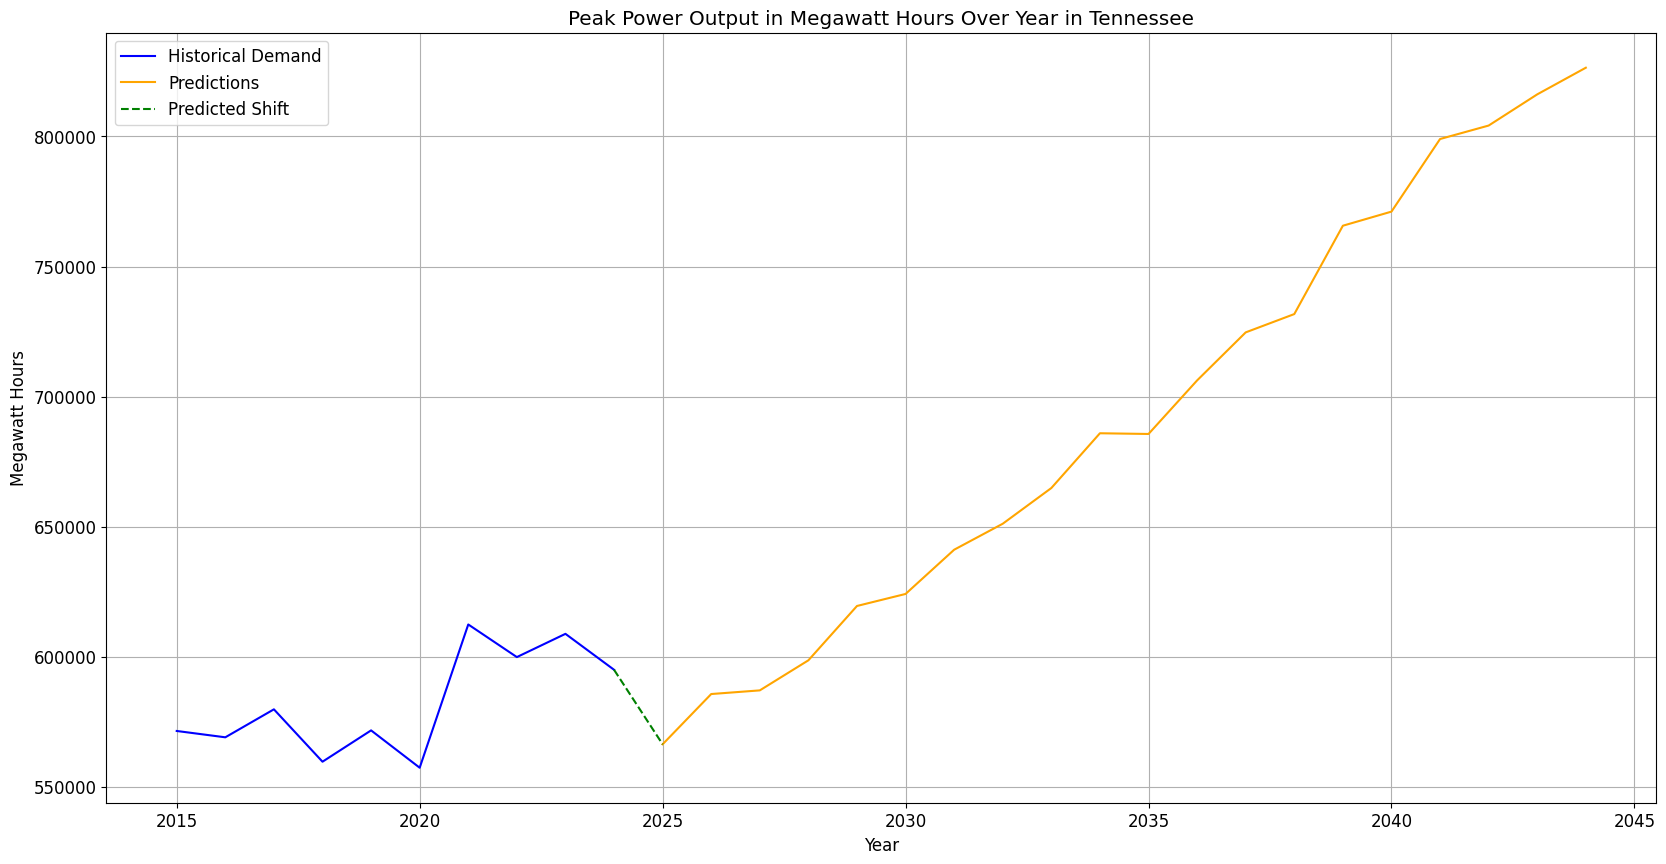

In [140]:
import matplotlib.pyplot as plt
import numpy as np

next_20_years = max_every_n_values(predictions)

# Example data for the next 20 years
plt.figure(figsize=(20, 10))
years_future = np.arange(2025, 2045)  # Years from 2025 to 2044
years_past = np.arange(2015, 2025)   # Years from 2015 to 2024

# Plot historical demand
past_values = max_every_n_values(df["Demand"])
plt.plot(years_past, past_values, color='blue', label='Historical Demand')

# Plot future predictions
plt.plot(years_future, next_20_years, color='orange', label='Predictions')

# Draw line connecting last historical value to first prediction
plt.plot([years_past[-1], years_future[0]], [past_values[-1], next_20_years[0]], color='green', linestyle='dashed', label='Predicted Shift')

plt.title("Peak Power Output in Megawatt Hours Over Year in Tennessee")
plt.xlabel("Year")
plt.ylabel("Megawatt Hours")

# Set x-axis labels every 5 years
plt.xticks(np.arange(2015, 2046, 5))

plt.legend()
plt.grid(True)
plt.show()


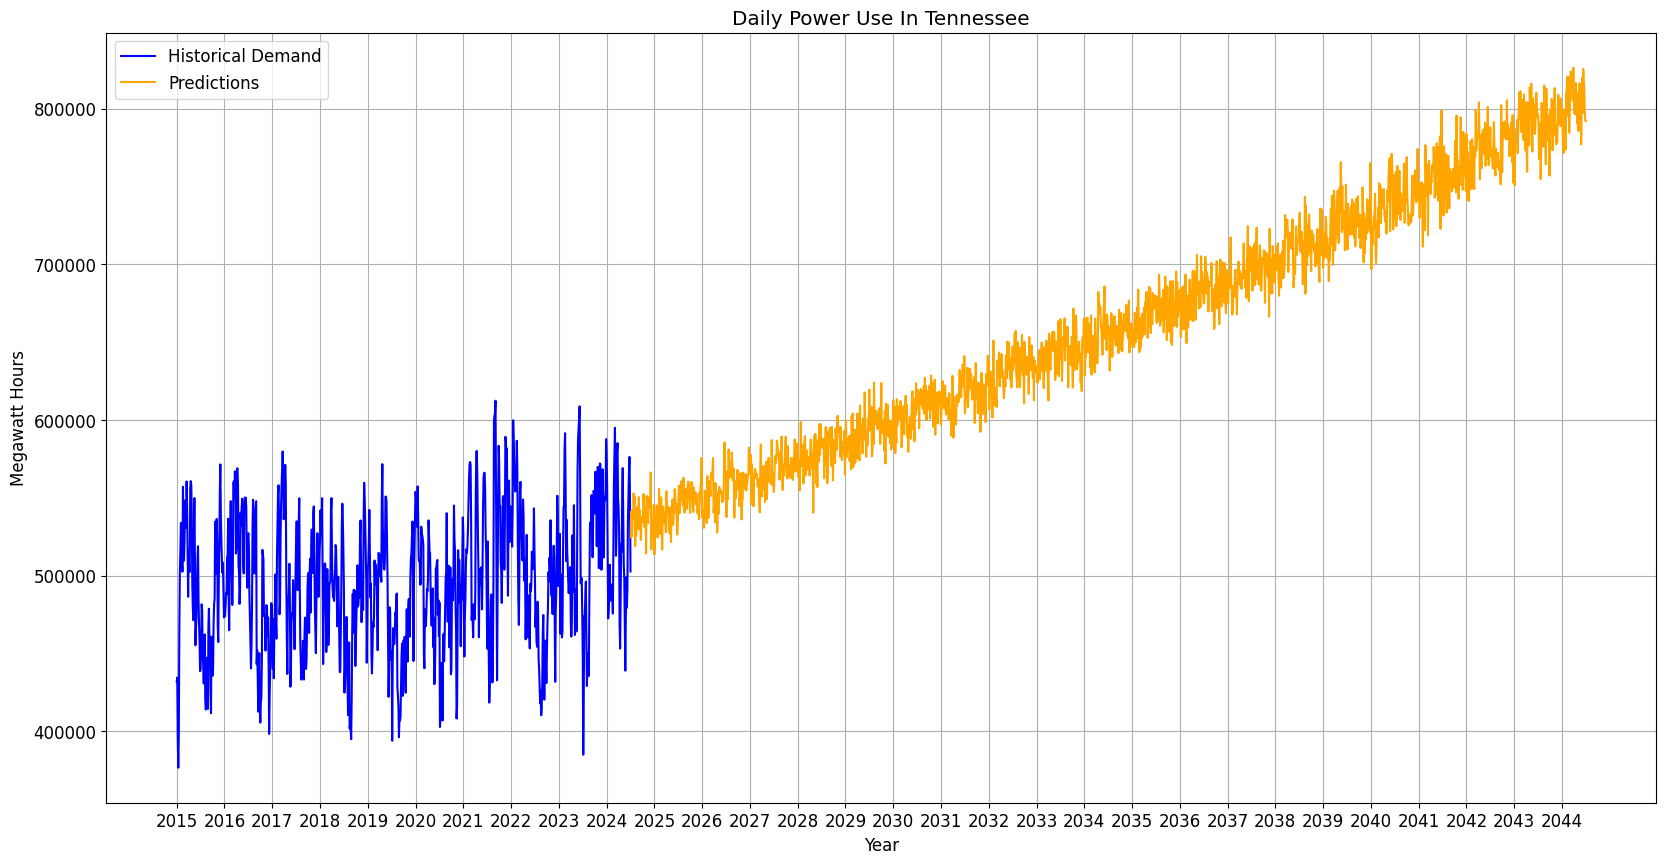

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Example setup
initial_demand = df["Demand"].values
future_predictions = np.array(predictions)

# Concatenate demand and predictions
all_data = np.concatenate([initial_demand, future_predictions])

# Create figure
plt.figure(figsize=(20, 10))

# Plot initial demand in one color
plt.plot(np.arange(len(initial_demand)), initial_demand, color='blue', label='Historical Demand')

# Plot future predictions in a different color
plt.plot(np.arange(len(initial_demand), len(all_data)), future_predictions, color='orange', label='Predictions')

plt.title("Daily Power Use In Tennessee")
plt.xlabel("Year")
plt.ylabel("Megawatt Hours")

# Set x-axis labels yearly, incrementing every 92 values
years = np.arange(2015, 2015 + len(all_data) // 92 + 1)
plt.xticks(np.arange(0, len(all_data) + 1, 92), years)

plt.legend()
plt.grid(True)
plt.show()


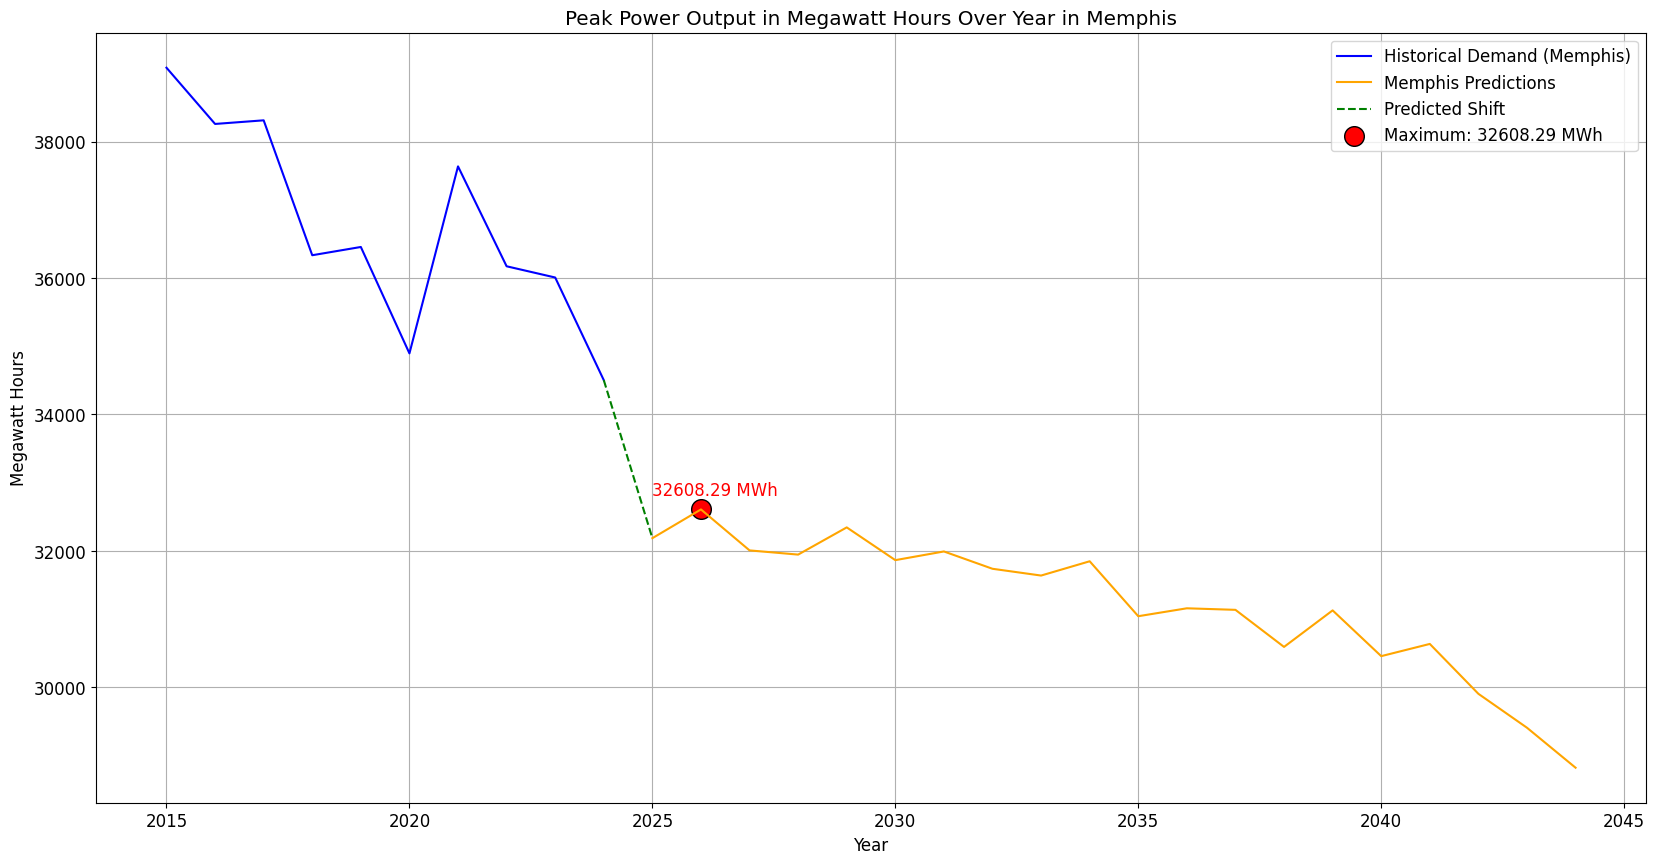

In [146]:
import matplotlib.pyplot as plt
import numpy as np

def tennessee_to_memphis(x):
    y = -0.115554 * x + 239.68008
    return y

# Example data for the next 20 years
plt.figure(figsize=(20, 10))
years_future = np.arange(2025, 2045)  # Years from 2025 to 2044
years_past = np.arange(2015, 2025)   # Years from 2015 to 2024

# Plot historical demand with Memphis adjustment
past_values = max_every_n_values(df["Demand"])
past_percents = tennessee_to_memphis(years_past) / 100  # Convert to decimal
memphis_past_values = past_values * past_percents
plt.plot(years_past, memphis_past_values, color='blue', label='Historical Demand (Memphis)')

# Calculate Memphis percent shift for future years
memphis_percents = tennessee_to_memphis(years_future) / 100  # Convert to decimal
memphis_predictions = next_20_years * memphis_percents

# Plot Memphis future predictions
plt.plot(years_future, memphis_predictions, color='orange', label='Memphis Predictions')

# Draw line connecting last historical value to first Memphis prediction
plt.plot([years_past[-1], years_future[0]], [memphis_past_values[-1], memphis_predictions[0]], 
         color='green', linestyle='dashed', label='Predicted Shift')

# Find maximum value and its corresponding year
max_value = np.max(memphis_predictions)
max_year = years_future[np.argmax(memphis_predictions)]

# Plot notation circle and label for maximum point
plt.scatter(max_year, max_value, color='red', s=200, edgecolors='black', label=f'Maximum: {max_value:.2f} MWh')
plt.annotate(f'{max_value:.2f} MWh', (max_year, max_value), textcoords="offset points", xytext=(10,10), ha='center', fontsize=12, color='red')

plt.title("Peak Power Output in Megawatt Hours Over Year in Memphis")
plt.xlabel("Year")
plt.ylabel("Megawatt Hours")

# Set x-axis labels every 5 years
plt.xticks(np.arange(2015, 2046, 5))

plt.legend()
plt.grid(True)
plt.show()